# Libraries

In [ ]:
# Data manipulation and plots
# ==============================================================================
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# set the default theme of seaborn
sns.set_theme()

# Custom functions
# ==============================================================================n
import db_function_aut as linked
import df_modify as mod

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data

In [ ]:
table = "observation_month"
df  = linked.get_dataFrame_by_table(table)

# fix names
mod.replace_name(df)
# df

df_filtered = df[df.eval(" accommodation_type_id == 'ALL'  and destination_id == 'Sardenga'  and origin_id == 'WRL_X_ITA' and observation_type_id == 'NI'")]

# filter by date
df = mod.filter_by_date(df_filtered,"2008-01-01","2019-12-01")


df_filtered['date'] = pd.to_datetime( df_filtered['date'], format="%Y-%m-%d")
df_select_date = df_filtered['date'].between('2008-01-01','2019-12-01')
data = df_filtered[df_select_date]
# remove useless columns for the train/test
data.drop(['observation_type_id', 'destination_id', 'origin_id', 'accommodation_type_id'], axis=1, inplace=True)

# Data preparation
data.columns = data.columns.str.replace('observation', 'y')
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')

# The last 12 months are used as the test set to evaluate the predictive capacity of the model.
# Split data into train-test

f_train = data[:-36]
f_test  = data[-36:]

f_train_y = f_train['y']
f_test_y  = f_test['y']

# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
ax.legend();
plt.show()

# ForecasterAutoreg

In [ ]:
# Create and train forecaster
forecaster = ForecasterAutoreg(
                regressor =  Ridge(),
                transformer_y = StandardScaler(),
                lags      = 30 # The time window that defines the rows of the feature matrix
             )

forecaster.fit(y=f_train_y)

# Predictions

In [ ]:
# the 36 months of testing plus the 60 unknowns
steps = 36 + 60

# prediction
f_pred = forecaster.predict(steps=steps)

# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
f_pred.plot(ax=ax, label='predictions')
ax.legend();

# Prediction error and accuracy in the test set

In [ ]:
mse_all = mean_squared_error(f_test_y, f_pred[:-60])
r2_all  = r2_score(f_test_y, f_pred[:-60])
print(" MSE:", mse_all, "  R2:", r2_all) 

# Final model

In [ ]:
# Create and train forecaster
fa_autoreg = ForecasterAutoreg(regressor = Ridge(alpha=0.001),
                              transformer_y = StandardScaler(),
                              lags = 20)

fa_autoreg.fit(y=f_train_y)


# prediction
fa_pred = fa_autoreg.predict(steps=steps)


# plot
fig, ax=plt.subplots(figsize=(12, 6))
f_train['y'].plot(ax=ax, label='train')
f_test['y'].plot(ax=ax, label='test')
fa_pred.plot(ax=ax, label='predictions')
ax.legend();
     

# Test error and accuracy
mse_all = mean_squared_error(f_test_y, fa_pred[:-60])
r2_all  = r2_score(f_test_y, fa_pred[:-60])
print(" MSE:", mse_all, "  R2:", r2_all) 

# Save and load model

/home/kindaglia/Documents/GitHub/Statea/FinTech/Predizone/generate all prediction/df_modify.py:22: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_selection = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
/tmp/ipykernel_2549/3380444482.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['observation_type_id', 'destination_id', 'origin_id', 'accommodation_type_id'], axis=1, inplace=True)
/tmp/ipykernel_2549/3380444482.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

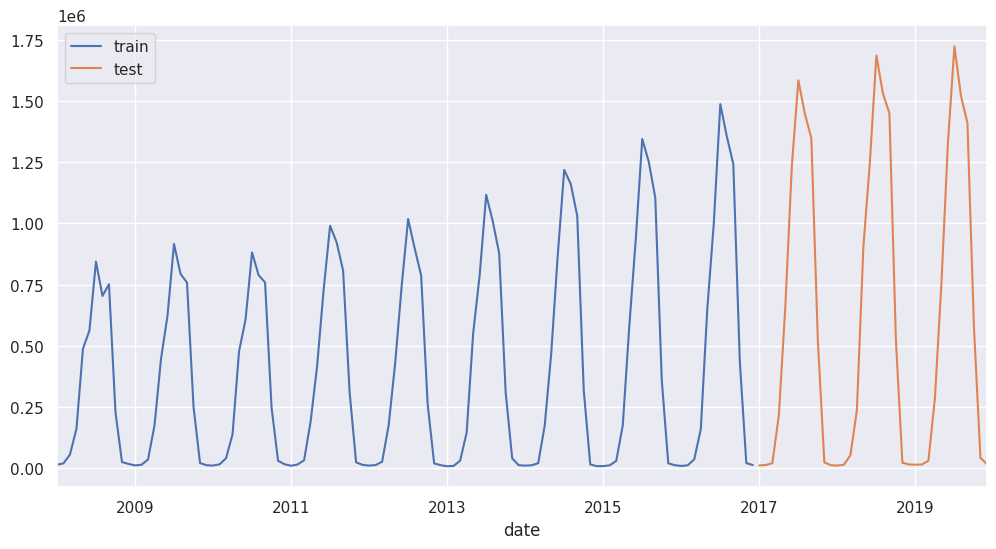

 MSE: 11926486856.067844   R2: 0.9706483779922958
 MSE: 11144188474.203169   R2: 0.9725736495897779


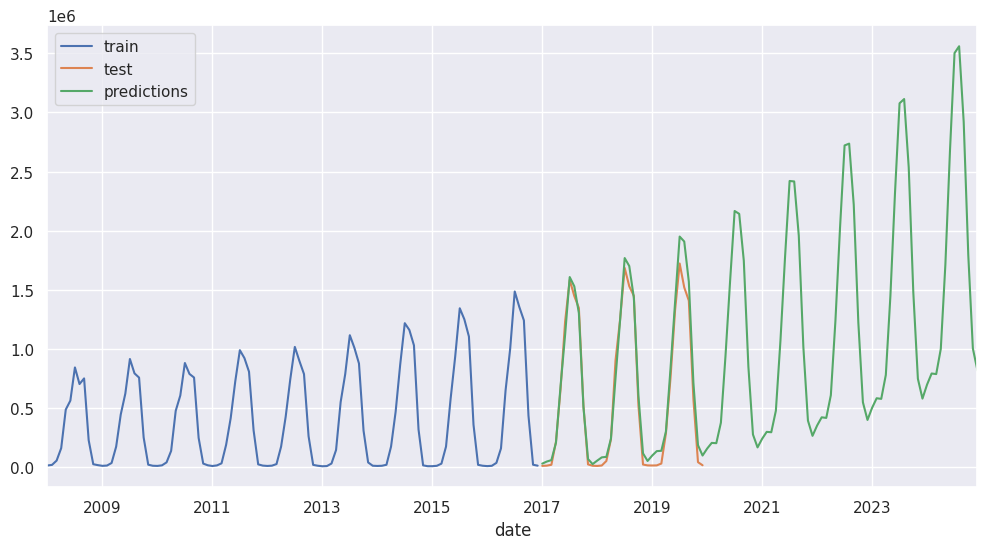

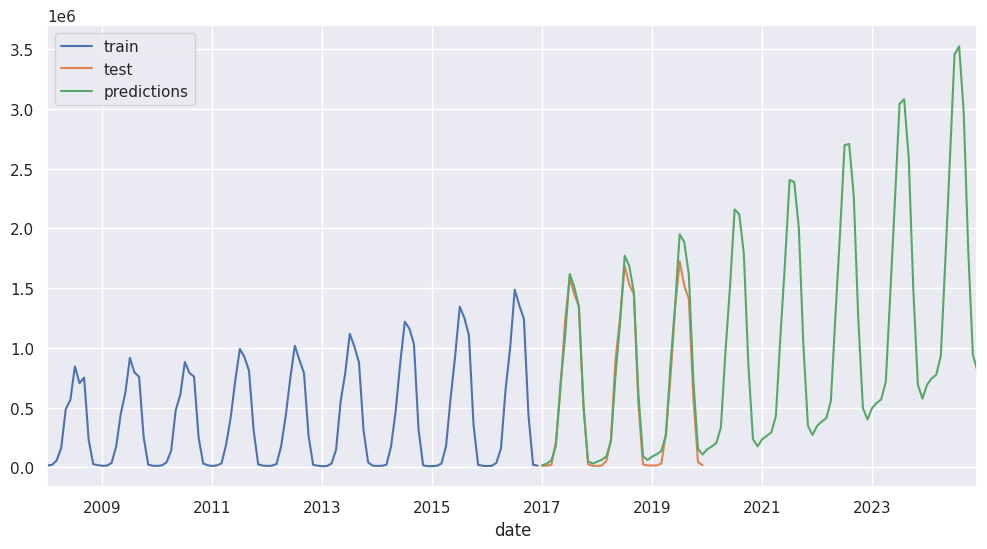

In [4]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data['y'])
forecaster.predict(steps=3)

# Save model
save_forecaster(forecaster, file_name='presenze.py', verbose=False)
